In [1]:
import pandas as pd
import json
import numpy as np

from enum import Enum
from collections import Counter
from plotnine import *
import autograd.numpy as anp

from enum import IntEnum

from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.factory import get_sampling, get_crossover, get_mutation

from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, brier_score_loss, log_loss

In [2]:
df = pd.read_csv("/Users/scottbarnett/projects/research/threshy/input/mailguard-labeled-results.csv")

inputs = {
    "id_column": "mid",
    "ground_truth_column": "ground_truth",
    "reject_label": "REJECT",
    "min": 0,
    "max": 1,
    
    "probability_column" : "probabilities",  # Optional???
    "target_label" : "spam",                 # Optional???
    
}

In [258]:
df = pd.read_csv("/Users/scottbarnett/projects/research/threshy/input/predictions-email-classifier-percept_20191014-161825.csv")
inputs = {
    "id_column": "email_id",
    "ground_truth_column": "work_type",
    "reject_label": "REJECT",
    "min": 0,
    "max": 100
}


## Data structure for calculating metrics for object dectction




In [3]:
def ids_are_unique(df, inputs):
    return len(df[inputs["id_column"]].unique()) == len(df[inputs["id_column"]])

def retrieve_labels(df, inputs):
    return df[inputs["ground_truth_column"]].str.strip().sort_values().unique()

def rejects_are_present(df, inputs):
    return df[inputs["ground_truth_column"]].str.strip().str.contains(inputs["reject_label"]).any()

def check_labels_have_columns(df, labels):
    return len(set(df.columns) & set(labels)) == len(labels)

def normalise_probs_in_place(df, inputs, labels):
    if inputs["min"] == 0 and inputs["max"] == 100:
        for label in labels:
            if label == inputs["reject_label"]:
                continue
            if (df[label] < 1).any() and (df[label] >= 0).any():
                return 
            df[label] = df[label] / 100      
    elif inputs["min"] == 0 and inputs["max"] == 1:
        # TODO: Check that the provided constraints are not violated 
        return
    else:
        raise ValueError("Normalisation rule not specified")
    
def prepare_labels(df, inputs):
    labels = retrieve_labels(df, inputs)

    if "target_label" in inputs:
        labels = list(filter(lambda x: x == inputs["target_label"], labels))
    
    if not check_labels_have_columns(df, labels) and not "probability_column" in inputs:
        raise ValueError("Labels do not have column names for probabilities")   
        
    return sorted(labels)


def prepare_ground_truth(df, inputs, mapping):
#    ids_are_unique(df, inputs)
    ids = []
    truth_columns = inputs["ground_truth_column"]

    if not "target_label" in inputs:
        all_labels = []
        for a_id in df[inputs["id_column"]].unique():
            ground_truth_labels = df[df[inputs["id_column"]] == a_id][truth_columns]
            indexes = [mapping[s.strip()] for s in list(ground_truth_labels)]     
            ground_truth = np.zeros(len(mapping), dtype=int)
            ground_truth[indexes] = 1
            ids.append(a_id)
            all_labels.append(ground_truth)
        columns = list(mapping.keys())
        ground_truth = pd.DataFrame(all_labels)
        ground_truth.columns = columns
    else:
        ids = df[inputs["id_column"]].unique()
        ground_truth = pd.DataFrame()
        ground_truth[inputs["target_label"]] = (df[truth_columns] == inputs["target_label"]) * 1
      
    ground_truth["id"] = ids    
    return ground_truth

labels = prepare_labels(df, inputs)
normalise_probs_in_place(df, inputs, labels)
mapping = {label: i for i, label in enumerate(labels)}

prepare_ground_truth(df, inputs, mapping)

,spam,id
0,0,5d2fce79df29c1
1,0,5d2fd05cdf1efc
2,0,5d2fcfc9df79a0
3,1,5d59d372de7118
4,0,5d2fd06fdf23b7
5,1,5d623b6dcc79c4
6,0,5d2fcee9df42a3
7,0,5d2fcef9df4632
8,1,5d55c6eacd0c54
9,1,5d62f005d260ec


In [4]:

if "probability_column" in inputs:
    probabilities = pd.DataFrame()
    probabilities[inputs["target_label"]] = df[inputs["probability_column"]]
    probabilities["id"] = df[inputs["id_column"]]
else:
    labels = list(retrieve_labels(df, inputs))
    labels.insert(0, inputs["id_column"])
    probabilities = df[labels]
    probabilities = probabilities.rename(columns={inputs["id_column"]: "id"})

probabilities

,spam,id
0,0.108118,5d2fce79df29c1
1,0.126697,5d2fd05cdf1efc
2,0.126697,5d2fcfc9df79a0
3,0.872877,5d59d372de7118
4,0.029807,5d2fd06fdf23b7
5,0.962248,5d623b6dcc79c4
6,0.040824,5d2fcee9df42a3
7,0.112074,5d2fcef9df4632
8,0.930738,5d55c6eacd0c54
9,0.872877,5d62f005d260ec


In [7]:
a = labels[0]
probabilities[a]

0     0.108118
1     0.126697
2     0.126697
3     0.872877
4     0.029807
5     0.962248
6     0.040824
7     0.112074
8     0.930738
9     0.872877
10    0.029807
11    0.126697
12    0.872877
13    0.012796
14    0.163702
15    0.280756
16    0.872877
17    0.872877
18    0.872877
19    0.194725
20    0.963605
21    0.096266
22    0.962248
23    0.126697
24    0.163702
25    0.126697
26    0.872877
27    0.126697
28    0.126697
29    0.029807
        ...   
70    0.508907
71    0.108118
72    0.963605
73    0.002700
74    0.126697
75    0.126697
76    0.126697
77    0.039276
78    0.508907
79    0.163702
80    0.126697
81    0.126697
82    0.126697
83    0.028334
84    0.979812
85    0.126697
86    0.962248
87    0.508907
88    0.126697
89    0.872877
90    0.126697
91    0.280756
92    0.930738
93    0.108118
94    0.872877
95    0.126697
96    0.126697
97    0.112074
98    0.872877
99    0.178631
Name: spam, Length: 100, dtype: float64

In [255]:
params = {
  "cost": {
    "matrix" : [[10,100, 10],[1000,10,10], [0,0,0]],
    "portion_size" : 1000,
    "estimate_size":10000
  },
  "reject" : True,
  "strategy" : "POINT_5",
}

class Strategy(Enum):
    POINT_5 = 0

In [31]:
def check_required_headers(df):
    required = ["ground_truth", "predictions", "probabilities"]
    return len(set(required) & set(df.columns)) == len(required)

In [418]:
check_required_headers(df), len(df)

(True, 100)

# Cost($) Estimates

In [34]:
def apply_threshold(df, lower_threshold, upper_threshold = None):
    if upper_threshold:
        def threshold(x):
            value = "REJECT"
            if x < lower_threshold:
                value = "ham"
            elif x > upper_threshold:
                value = "spam"
            return value 
        return [threshold(p) for p in df["probabilities"]]
    else:
        return ["ham" if p < lower_threshold else "spam" for p in df["probabilities"]]

def apply_strategy(df, params):
    result = None
    if Strategy.POINT_5 == Strategy[params["strategy"]]:
        result = apply_threshold(df, 0.5)        
    return result
    
def apply_cost(df, new_result, params):
    cost_per_prediction = np.array(params["cost"]["matrix"]) / params["cost"]["portion_size"]
    labels = ["ham", "spam"]
    if "reject" in params and params["reject"]:
        labels.append("REJECT")
    percentages = confusion_matrix(df["ground_truth"], new_result, labels=labels) / confusion_matrix(df["ground_truth"], new_result).sum()
    scaled = percentages * params["cost"]["estimate_size"]
    return scaled * cost_per_prediction, scaled

In [35]:
new_result = apply_strategy(df, params)    
format("For strategy %s, %d predictions are estimated to cost $%0.2f" % (params["strategy"], params["cost"]["estimate_size"], apply_cost(df, new_result, params)[0].sum()))

'For strategy POINT_5, 10000 predictions are estimated to cost $1810.00'

## Assumptions for the cost
- The predicted confusion matrix is representative of the production environment
- Estimates provided for each of the fields are available and representative
- Cost estimates only consider factors used to derive the initial estimates

# Label Bias Estimates

In [2]:
def label_bias_estimate(new_result):
    counter = Counter(new_result)
    counter.subtract(Counter(df["ground_truth"]))
    Counter(df["ground_truth"]), Counter(new_result), counter
    return counter

In [1]:
new_result = apply_strategy(df, params)  
for a in sorted(label_bias_estimate(new_result).items(), key=lambda x: x[1], reverse=True):
    print(a[1])
    print(format("Label %s has bias of %0.1f%%" % (a[0], 100 * a[1] / float(len(new_result)))))

NameError: name 'apply_strategy' is not defined

## Assumptions for the label bias estimates
- No bias introduced by selected features are analysed. Use FairML or other techniques
- Class imbalance in the test data a representative sample of the phenomena (Note: Guiance on how to sample required???)


# Reject Estimates

In [375]:
new_result = apply_threshold(df, 0.3, 0.8)

cost, scale = apply_cost(df, new_result, params)
reject_count = scale[:,-1].sum()

format("With %d rejects, %d predictions are estimated to cost $%0.2f" % (reject_count, params["cost"]["estimate_size"], cost.sum()))

'With 500 rejects, 10000 predictions are estimated to cost $1693.00'

In [372]:
confusion_matrix(df["ground_truth"], new_result, labels=["ham", "spam", "REJECT"])

array([[46,  1,  2],
       [16, 32,  3],
       [ 0,  0,  0]])

## Assumptions for rejects
- The reject propotion in the sample set is representative of real life
- There is a manual process for handling unclassified items

# Calibration 

In [506]:
brier_score_loss(df["ground_truth"], df["probabilities"], pos_label=0), log_loss(df["ground_truth"], df["probabilities"])

(0.29728739041636, 0.5320022228450445)

In [498]:
b = pd.DataFrame(calibration_curve(df["ground_truth"], df["probabilities"], n_bins=10)).transpose()
b.columns = ["true_prob", "mean_prob"]

b

,true_prob,mean_prob
0,0.294118,0.035576
1,0.214286,0.131054
2,0.666667,0.280756
3,1.000000,0.461111
4,0.500000,0.508907
5,1.000000,0.872877
6,0.933333,0.957660


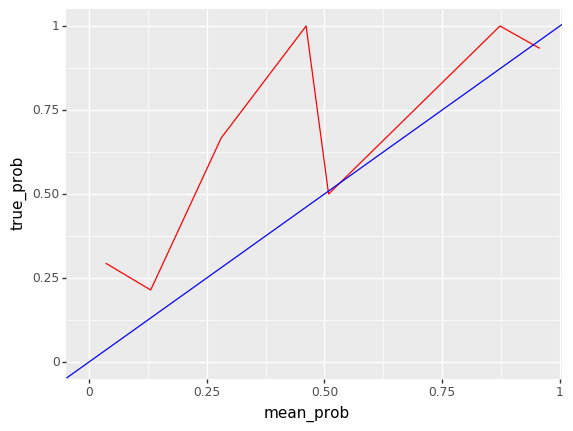

<ggplot: (316726133)>

In [494]:
(ggplot(b, aes("mean_prob", "true_prob")) + 
    geom_line(color="r") +
    geom_abline(color="b") +
    expand_limits(x = 0, y = 0)
)

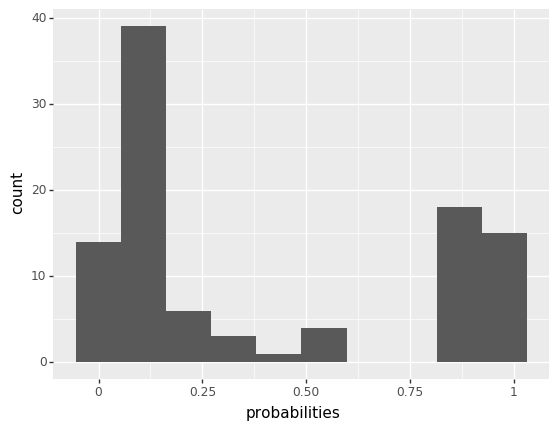

<ggplot: (313169333)>

In [470]:
(ggplot(df, aes("probabilities")) 
 + geom_histogram(bins=10))

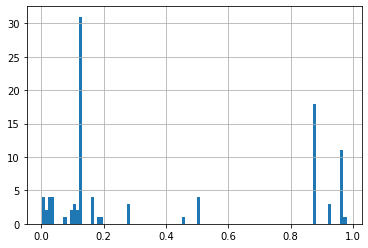

In [473]:
df["probabilities"].hist(bins=100)

In [475]:
calibration_curve(df["ground_truth"], df["probabilities"], n_bins=10)

(array([0.29411765, 0.21428571, 0.66666667, 1.        , 0.5       ,
        1.        , 0.93333333]),
 array([0.03557624, 0.13105412, 0.280756  , 0.461111  , 0.508907  ,
        0.872877  , 0.95765973]))

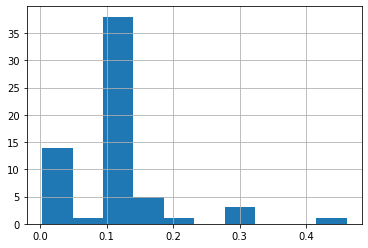

In [509]:
df[df["predictions"] == "ham"]["probabilities"].hist()

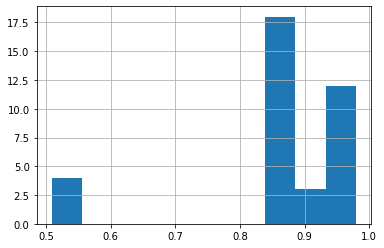

In [510]:
df[df["predictions"] == "spam"]["probabilities"].hist()

/usr/local/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 3'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)
/usr/local/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_bin : Removed 2 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/usr/local/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


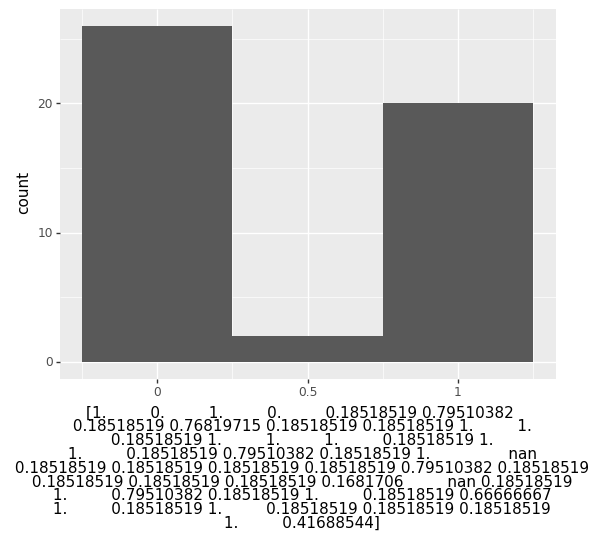

<ggplot: (317987057)>

In [530]:
from sklearn.isotonic import IsotonicRegression


p_hat = df["probabilities"]
y = LabelEncoder().fit_transform(df["ground_truth"])



iso_reg = IsotonicRegression().fit(p_hat[0:50], y[0:50])

q = iso_reg.predict(p_hat[50:])

calibration_curve(df["ground_truth"][50:], q)

# Optimisation

In [475]:
a = np.array([[0.41868156, 0.715918  ],
 [0.01011209 ,0.30628592],
 [0.19253501, 0.34864951],
 [0.39883212, 0.5380404 ],
 [0.42081062, 0.68151511],
 [0.2103632 , 0.87055509],
 [0.03683984, 0.66705816],
 [0.41895871, 0.55751603],
 [0.1475792 , 0.20413946],
 [0.79472968, 0.95889634],
 [0.31715569, 0.68847616],
 [0.86886137, 0.88671453]])

#a =  np.array([[0.5, 0.5]])

In [267]:
probs = df["probabilities"].to_numpy()

class Result(IntEnum):
    NOT_MATCH = 0
    MATCH = 1
    REJECT = 2

def thres(x, lower, upper):
    not_match = np.less(x, lower)
    match = np.greater_equal(x, upper)
    rejects = ~np.logical_xor(not_match, match)
    return np.stack([not_match, match, rejects])
        
def try_thresholds(element):
    lower = element[0]
    upper = element[1]
    if upper < lower:
        raise ValueError("Upper threshold %0.2f cannot be less than the lower threshold %0.2f" % (upper, lower))
    return np.apply_along_axis(thres, 0, probs, lower, upper)

# all_values = np.apply_along_axis(try_thresholds, 1, a)

# rejects = all_values[:,Result.REJECT].sum(axis=1)
# rejects
thres(probabilities["spam"], 0.5, 0.5)

array([[ True,  True,  True, False,  True, False,  True,  True, False,
        False,  True,  True, False,  True,  True,  True, False, False,
        False,  True, False,  True, False,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True, False,  True, False,  True, False,
        False, False,  True,  True,  True, False,  True, False,  True,
         True, False,  True,  True,  True,  True, False, False,  True,
        False, False, False,  True, False, False,  True, False,  True,
        False,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True, False, False,  True, False,
         True,  True, False,  True, False,  True,  True,  True, False,
         True],
       [False, False, False,  True, False,  True, False, False,  True,
         True, False, False,  True, False, False, False,  True,  True,
         True, False,  True, False,  True, False, False, Fals

In [547]:
values = all_values

# Provided by the user to match the data they uploaded!
mapping = {Result.MATCH: "spam", Result.NOT_MATCH: "ham", Result.REJECT: "REJECT"}

def matches(x):
    return np.where(x == True)


#

def calculate_matches(x):
    print(np.shape(x))
    raise ValueError()
    return np.apply_along_axis(matches, 0, x)

np.apply_along_axis(calculate_matches, values, 0)
#

#results = np.where(values == True)


#sorted_index = np.argsort(results)[1]



#get_mapping = np.vectorize(lambda x: mapping[x])



#df["new_predictions"] = np.apply_along_axis(get_mapping, 0, results[0][sorted_index])
# Sanity check 

#len(df[df["new_predictions"] == "REJECT"])


TypeError: only size-1 arrays can be converted to Python scalars

In [220]:
def apply_cost(df, new_result, params):
    cost_per_prediction = np.array(params["cost"]["matrix"]) / params["cost"]["portion_size"]
    labels = ["ham", "spam"]
    if "reject" in params and params["reject"]:
        labels.append("REJECT")
    percentages = confusion_matrix(df["ground_truth"], new_result, labels=labels) / confusion_matrix(df["ground_truth"], new_result).sum()
    scaled = percentages * params["cost"]["estimate_size"]
    return scaled * cost_per_prediction, scaled


percentages = confusion_matrix(ground_truth, new_result, labels=labels) / confusion_matrix(ground_truth, new_result).sum()

def calculate_cost(matrix, portion_size, labels, ground_truth):
    cost_per_prediction = np.array(matrix) / portion_size
    percentages = 
    return cost_per_prediction

calculate_cost(params["cost"]["matrix"], params["cost"]["portion_size"], ["ham", "spam", "REJECT"], df["ground_truth"])

array([[0.01, 0.1 , 0.01],
       [1.  , 0.01, 0.01],
       [0.  , 0.  , 0.  ]])

In [179]:
class FindThresholds(Problem):
    def __init__(self):
        super().__init__(n_var=2, n_constr=2, n_obj=3, xl=anp.array([0.01,0.01]), xu=anp.array([0.99,0.99]))
    
    def _evaluate(self, x, out, *args, **kwargs):

        new_result = apply_thresholds(df, x[:,0], x[:,1])
        
        # Calculate cost
        cost, _ = apply_cost(df, new_result, params)        
        f_cost = cost.sum()
        
        # Calculate rejects
        count = Counter(new_result)
        f_rejects = count["REJECT"] if "REJECT" in count else 0

        
        out["F"] = anp.column_stack([f_cost, f_rejects])
        out["G"] = anp.column_stack([x[:,0] - x[:,1]])

        

In [172]:
algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 40)

In [173]:
problem = FindThresholds()
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

<class 'numpy.ndarray'>


ValueError: operands could not be broadcast together with shapes (100,) (40,) 

In [ ]:

from pymoo.factory import get_problem

class TNK(Problem):
    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=2, type_var=anp.double)
        self.xl = anp.array([0, 1e-30])
        self.xu = anp.array([anp.pi, anp.pi])

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = x[:, 0]
        f2 = x[:, 1]
        print(f1)
        raise ValueError("HERE")

        g1 = -(anp.square(x[:, 0]) + anp.square(x[:, 1]) - 1.0 - 0.1 * anp.cos(16.0 * anp.arctan(x[:, 0] / x[:, 1])))
        g2 = 2 * (anp.square(x[:, 0] - 0.5) + anp.square(x[:, 1] - 0.5)) - 1

        out["F"] = anp.column_stack([f1, f2])
        out["G"] = anp.column_stack([g1, g2])

    def _calc_pareto_front(self, *args, **kwargs):
        return load_pareto_front_from_file("tnk.pf")

from pymoo.factory import get_sampling, get_crossover, get_mutation

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)

from pymoo.factory import get_termination, get_decomposition

termination = get_termination("n_gen", 40)

from pymoo.optimize import minimize

res = minimize(TNK(),
               algorithm,
               termination,
               seed=1,
               pf=problem.pareto_front(use_cache=False),
               save_history=True,
               verbose=True)

F = res.F
weights = np.array([0.5, 0.5])
I = get_decomposition("asf").do(F, weights).argmin()
print("Best regarding decomposition: Point %s - %s" % (I, F[I]))